# Find a Single-Hard Example on TAO-Amodal-Train

In [1]:
import os 
import json
from collections import defaultdict
annotation_path = '/compute/trinity-1-38/chengyeh/TAO/amodal_annotations/validation_with_freeform_amodal_boxes_Aug10_2022_GTR_lvis_v1.json'

with open(annotation_path, 'r') as f:
    tao_amodal = json.load(f)

img_id_to_annotations = defaultdict(list)

In [2]:
for ann in tao_amodal['annotations']:
    img_id_to_annotations[ann['image_id']].append(ann)

img_id_to_image = {image['id']: image for image in tao_amodal['images']}

## Display Image 50647

Number of images with annotations: 34383
Number of images: 36562
8869
8870
8877
8872


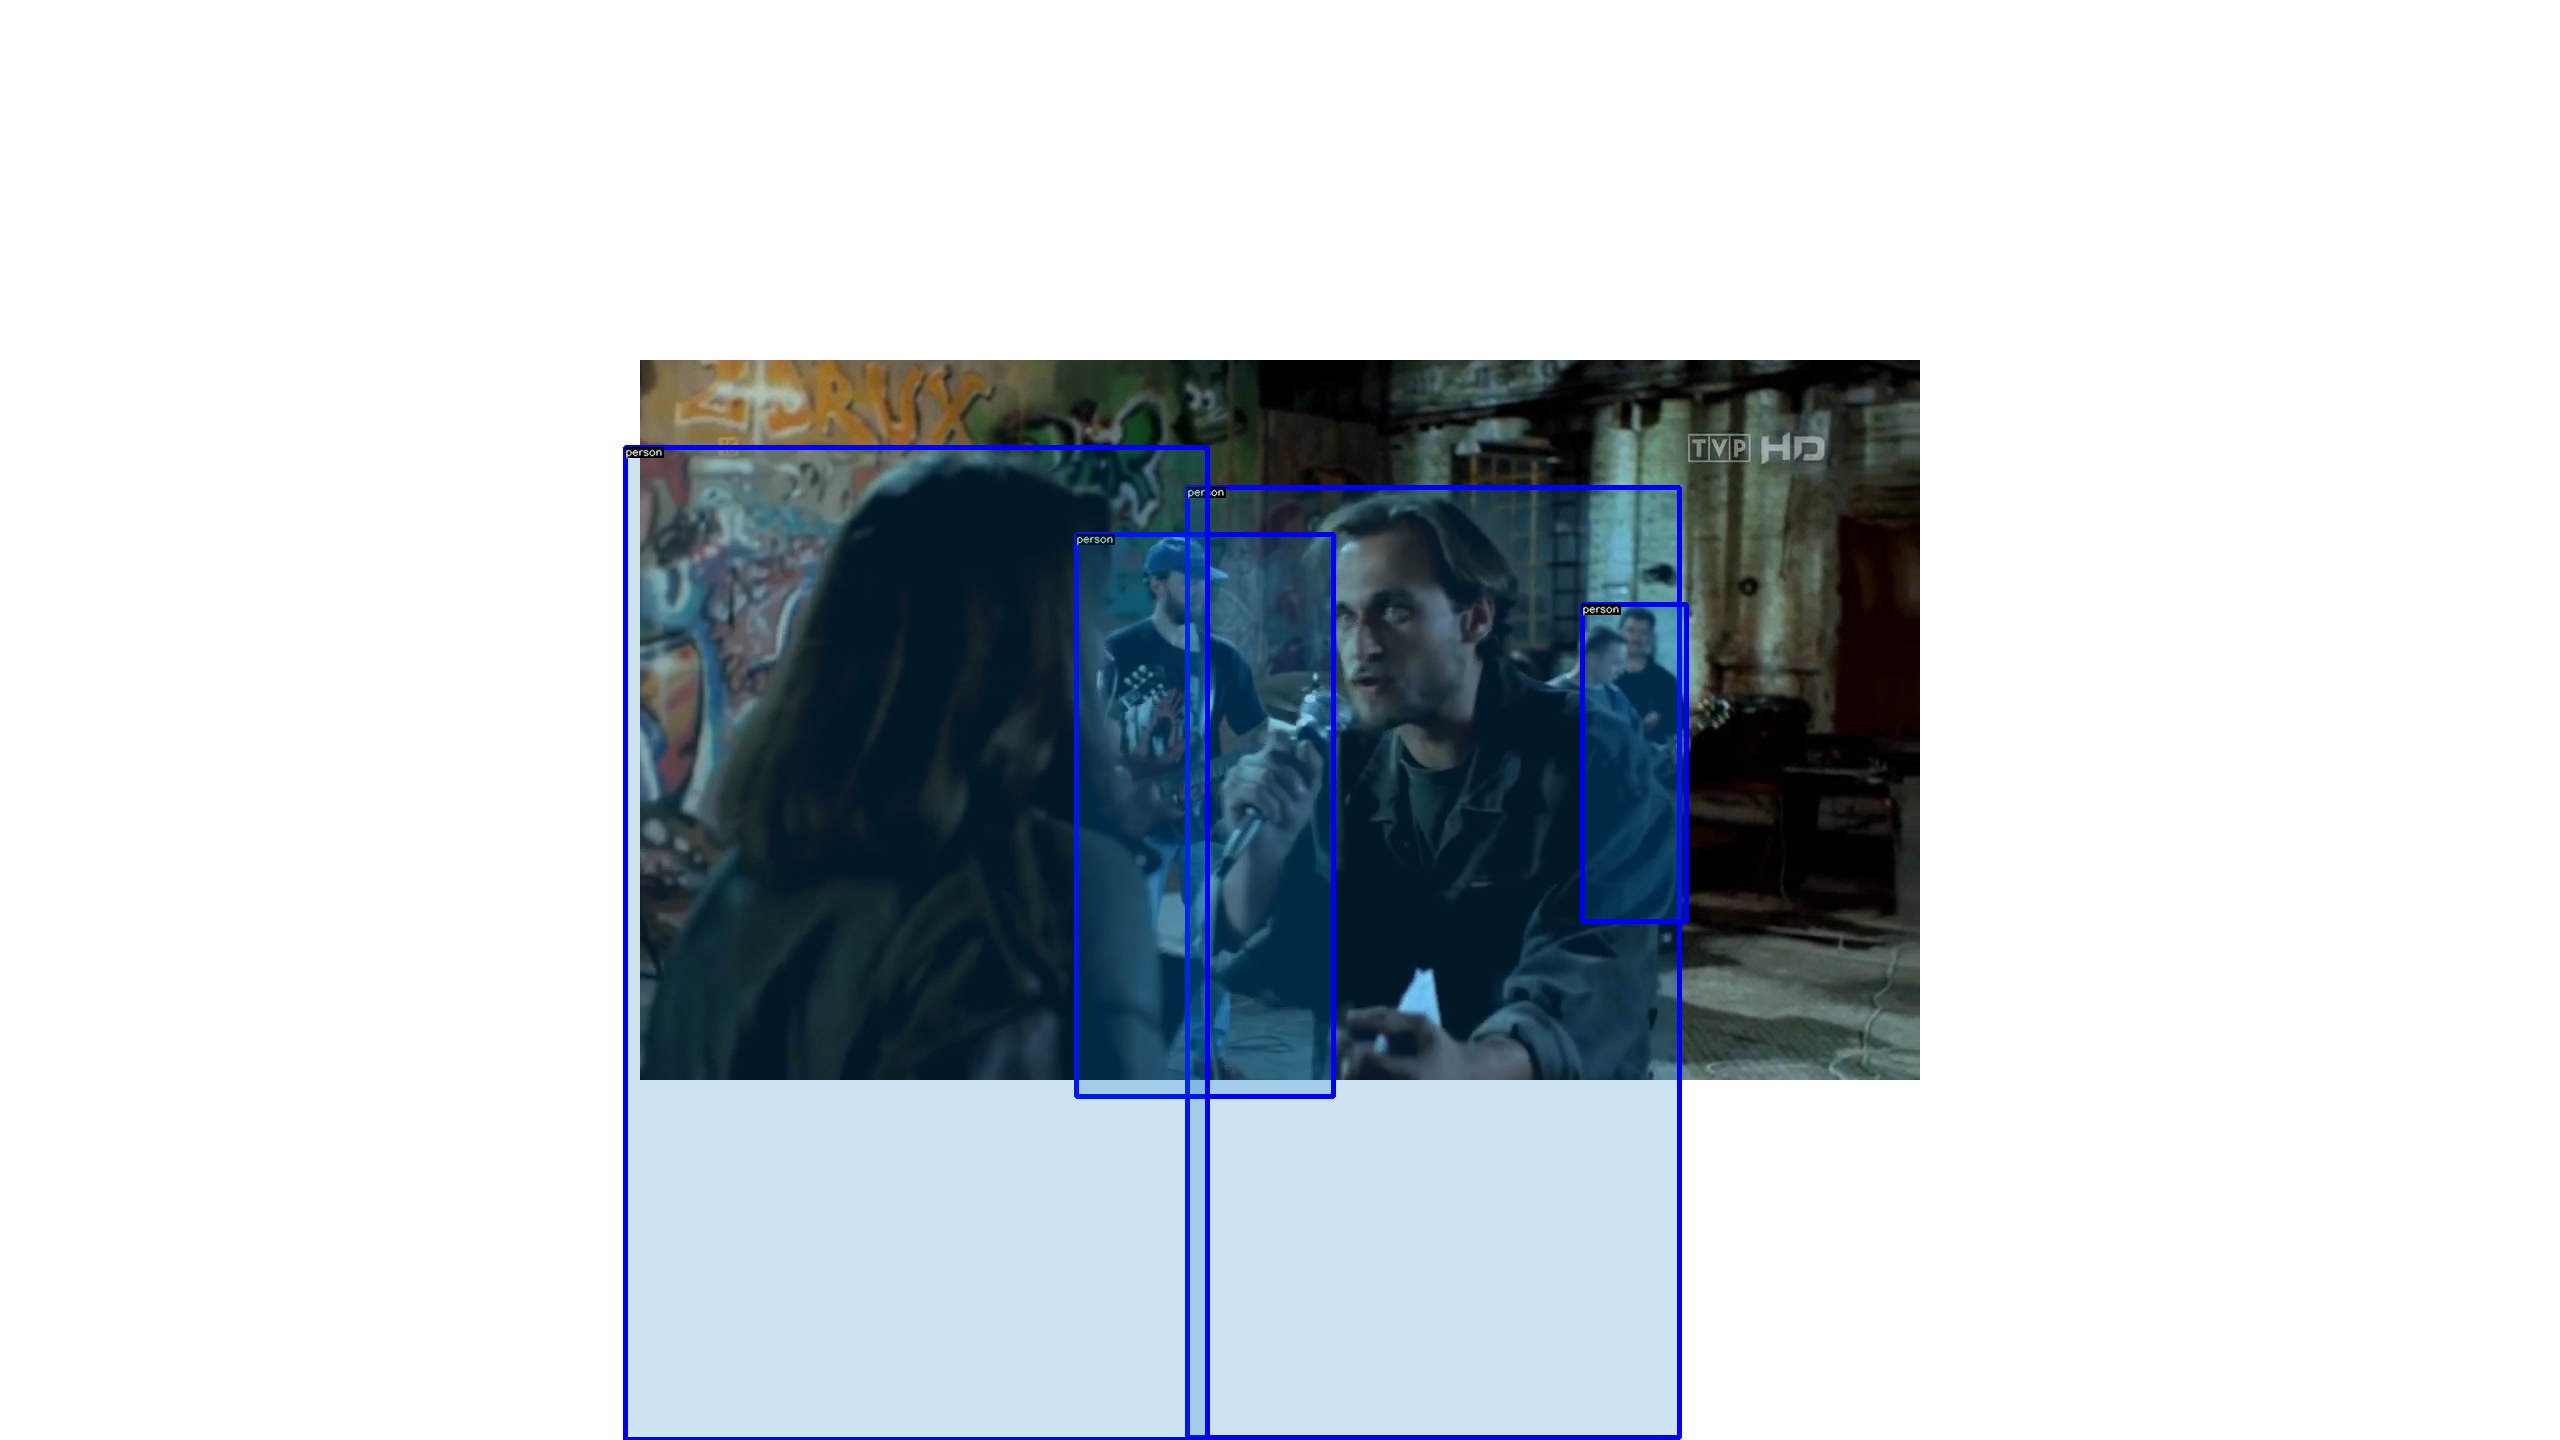

{'id': 50647, 'video': 'val/AVA/keUOiCcHtoQ_scene_23_102872-103750', '_scale_task_id': '5db68c5031f3e647131e3922', 'width': 1280, 'height': 720, 'file_name': 'val/AVA/keUOiCcHtoQ_scene_23_102872-103750/frame0326.jpg', 'frame_index': 325, 'license': 0, 'video_id': 1344, 'neg_category_ids': [530, 118, 189, 639, 285], 'not_exhaustive_category_ids': [793, 685, 521]}
[{'bbox': [547.0, 127.8111870877076, 492.10147245440567, 949.9724121678496], 'area': 467482, 'iscrowd': 0, 'id': '1344_50647_8869', 'image_id': 50647, 'category_id': 793, 'track_id': 8869, '_scale_uuid': '70030e41-c787-47c0-8050-b5dc2ae0d6d5', 'scale_category': 'person', 'video_id': 1344, 'amodal_bbox': [547.0, 127.8111870877076, 492.10147245440567, 949.9724121678496], 'amodal_is_uncertain': False}, {'bbox': [436.52782351522296, 174.6276861280952, 256.7356398989, 561.7979884846515], 'area': 144233, 'iscrowd': 0, 'id': '1344_50647_8870', 'image_id': 50647, 'category_id': 793, 'track_id': 8870, '_scale_uuid': '2ebeab1c-dbef-479e-

In [9]:
import cv2
import numpy as np

from detectron2.data import detection_utils as utils
from IPython.display import display
from PIL import Image

_BLACK = (0, 0, 0)
_RED = (255, 0, 0)
_BLUE = (0, 0, 255)
_GRAY = (218, 227, 218)
_GREEN = (18, 127, 15)
_WHITE = (255, 255, 255)

_COLOR1 = tuple(255*x for x in (0.000, 0.447, 0.741))

def vis_image_and_annotations(image, all_annos):
    height, width = image.shape[:2]
    new_image = np.ones([height * 2, width * 2, 3], dtype=np.uint8) * 255
    startx = int(width / 2)
    endx = startx + width
    starty = int(height / 2) 
    endy = starty + height
    new_image[starty: endy, startx: endx, :] = image

    with open('/home/chengyeh/TAO-Amodal-Root/TAO-GTR/datasets/lvis/lvis_v1_train+coco_box.json', 'r') as f:
        lvis = json.load(f)
        id_to_cat_name = {cat['id']: cat['name'] for cat in lvis['categories']}

    for ann in all_annos:
        if ann['category_id'] != 793 or ann['track_id'] in [8871, 8878]:
            continue
        print(ann['track_id'])
        oy, ox = new_image.shape[:2]
        oy, ox = int(oy / 4), int(ox / 4)

        box = ann['bbox']
        box = [box[0]+ox, box[1]+oy, box[0] + box[2]+ox, box[1] + box[3]+oy]
        new_image = vis_bbox(new_image, box, fill_opacity=0.2, border_color=_BLUE, thickness=3)
        new_image = vis_class(new_image, box[:2], id_to_cat_name[ann['category_id']])
    

    # Check bounding box, Check Category
    pil_image = Image.fromarray(new_image)
    return pil_image

def vis_class(image,
              pos,
              class_str,
              font_scale=0.35,
              bg_color=_BLACK,
              text_color=_GRAY,
              thickness=1):
    """Visualizes the class."""
    x, y = int(pos[0]), int(pos[1])
    # Compute text size.
    txt = class_str
    font = cv2.FONT_HERSHEY_SIMPLEX
    ((txt_w, txt_h), _) = cv2.getTextSize(txt, font, font_scale, 1)
    # Place text background.
    back_tl = x, y
    back_br = x + txt_w, y + int(1.3 * txt_h)
    # Show text.
    txt_tl = x, y + int(1 * txt_h)
    cv2.rectangle(image, back_tl, back_br, bg_color, -1)
    cv2.putText(image,
                txt,
                txt_tl,
                font,
                font_scale,
                text_color,
                thickness=thickness,
                lineType=cv2.LINE_AA)
    return image

def vis_bbox(image,
             box,
             border_color=_BLACK,
             fill_color=_COLOR1,
             fill_opacity=0.65,
             thickness=1):
    """Visualizes a bounding box."""
    x0, y0, x1, y1 = box
    x1, y1 = int(x1), int(y1)
    x0, y0 = int(x0), int(y0)
    # Draw border
    if fill_opacity > 0 and fill_color is not None:
        with_fill = image.copy()
        with_fill = cv2.rectangle(with_fill, (x0, y0), (x1, y1),
                                  tuple(fill_color), cv2.FILLED)
        image = cv2.addWeighted(with_fill, fill_opacity, image,
                                1 - fill_opacity, 0, image)
        
    image = cv2.rectangle(image, (x0, y0), (x1, y1), tuple(border_color),
                          thickness)
    return image

print('Number of images with annotations: {}'.format(len(img_id_to_annotations)))
print('Number of images: {}'.format(len(tao_amodal['images'])))

IMAGE_ROOT='/compute/trinity-1-38/chengyeh/TAO/frames'

image = img_id_to_image[50647]
img_path = os.path.join(IMAGE_ROOT, image['file_name'])
np_image = utils.read_image(img_path)
pil_image = vis_image_and_annotations(np_image, img_id_to_annotations[image['id']])


display(pil_image)
print(image)
print(img_id_to_annotations[50647])


## Save Image and Annotations with Image id 50647

In [10]:
print('Number of images: {}'.format(len(tao_amodal['images'])))
print('Number of annotations: {}'.format(len(tao_amodal['annotations'])))
new_images = [image for image in tao_amodal['images'] if image['id'] == 50647]
new_annotations = [ann for ann in tao_amodal['annotations'] if ann['image_id'] == 50647]


tao_amodal['images'] = new_images
tao_amodal['annotations'] = new_annotations
print('Number of images: {}'.format(len(tao_amodal['images'])))
print('Number of annotations: {}'.format(len(tao_amodal['annotations'])))

annotation_path = annotation_path.replace('GTR_lvis_v1.json', 'Overfit_Single_Example_GTR_lvis_v1.json')
with open(annotation_path, 'w') as f:
    json.dump(tao_amodal, f)

Number of images: 36562
Number of annotations: 119996
Number of images: 1
Number of annotations: 9
